# Notebook for processing VSM data from the IRM

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import statsmodels.api as sm

import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from random import randrange
import random
import seaborn as sns
from scipy import special
from scipy.optimize import minimize
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats.mstats import mquantiles
import math
from statistics import mean
from statistics import stdev

import sys
sys.path.append('../../RockmagPy/')

from RockmagPy import*

%config InlineBackend.figure_format = 'retina'

In [2]:
# Loading IRM data file
rockmag_data = pd.ExcelFile('../data/Rock_mag_data/SSRM2022C_IRMDB_export.xlsx')
specimen_info = pd.read_excel(rockmag_data, 'Specimen Info')
VSM_bf_measurements = pd.read_excel(rockmag_data, 'VSM backfield measurements')
hysteresis_properties = pd.read_excel(rockmag_data, 'hysteresis properties')
hysteresis_properties = hysteresis_properties.drop(0)
hysteresis_measurements = pd.read_excel(rockmag_data, 'hysteresis measurements')


## load Day (1977) compilation of synthetic samples

In [4]:
Day1977a = pd.read_csv('../data/Rock_mag_data/Day1977a_compilation.csv')

In [5]:
def fit_inverse(data, ab):
    def minimize_ab(ab):
        a=ab[0]
        b=ab[1]
        residual=0
        for x,y in zip(data[:,0], data[:,1]):
            model_y = a/x**b
            residual = residual+(model_y-y)**2
        return np.sqrt(residual)
    
    return minimize(minimize_ab, ab, method='Nelder-Mead')['x']
    

In [6]:
Day1977_fit = fit_inverse(Day1977a.iloc[:,2:4].to_numpy(), [4,3])

## make day plot

In [7]:
DX_hysteresis_properties = hysteresis_properties[hysteresis_properties['specimen'].str.contains('DX') 
                                                 & hysteresis_properties['Bcr [mT]'] > 0]
DA_hysteresis_properties = hysteresis_properties[hysteresis_properties['specimen'].str.contains('DA')]

In [8]:
DX_hysteresis_properties.head()

,specimen,Ms [Am/kg],Mr [Am/kg],Bc [mT],Bcr [mT],Xhf [m3/kg],T [K],Dec [deg],Inc [deg],HIRM [Am2/kg],...,alpha,beta,Xhf2[m3/kg],Ms2[Am2/kg],Q,Qf,FNL,FNL70,FNL80,FNL90
5,DX1-4r,0.00049,0.000186,27.6974,52.3327,1.714940e-08,294.0,0.0,0.0,0.000003,...,0.0,-2.0,0.0,0.0,2.91247,1.48810,10353.10,3.20912,3.07763,0.0
6,DX1-4r,0.00049,0.000186,27.6974,65.6216,1.714940e-08,294.0,0.0,0.0,0.000016,...,0.0,-2.0,0.0,0.0,2.91247,1.48810,10353.10,3.20912,3.07763,0.0
7,DX1-4r,0.00049,0.000186,27.6974,56.7840,1.714940e-08,294.0,0.0,0.0,0.000019,...,0.0,-2.0,0.0,0.0,2.91247,1.48810,10353.10,3.20912,3.07763,0.0
8,DX1-4r,0.00128,0.000290,20.1401,52.3327,1.253400e-08,294.0,0.0,0.0,0.000003,...,0.0,-2.0,0.0,0.0,2.83980,1.89203,1461.58,2.93077,3.03551,0.0
9,DX1-4r,0.00128,0.000290,20.1401,65.6216,1.253400e-08,294.0,0.0,0.0,0.000016,...,0.0,-2.0,0.0,0.0,2.83980,1.89203,1461.58,2.93077,3.03551,0.0


In [9]:
DX_hysteresis_properties.groupby('specimen').mean()

,Ms [Am/kg],Mr [Am/kg],Bc [mT],Bcr [mT],Xhf [m3/kg],T [K],Dec [deg],Inc [deg],HIRM [Am2/kg],S100,...,alpha,beta,Xhf2[m3/kg],Ms2[Am2/kg],Q,Qf,FNL,FNL70,FNL80,FNL90
specimen,,,,,,,,,,,,,,,,,,,,,
DX1-4r,0.001030,0.000253,22.3114,58.2461,1.404080e-08,294.0,0.0,0.0,0.000013,0.423628,...,0.000000,-2.0,0.0,0.0,2.926500,1.87183,4615.36,2.675960,2.634183,0.0
DX1-5r2,0.000548,0.000219,26.1228,55.1131,1.385510e-08,294.0,0.0,0.0,0.000007,0.477187,...,-0.000013,-1.1,0.0,0.0,3.059315,2.13528,55517.95,1.820555,1.620965,0.0


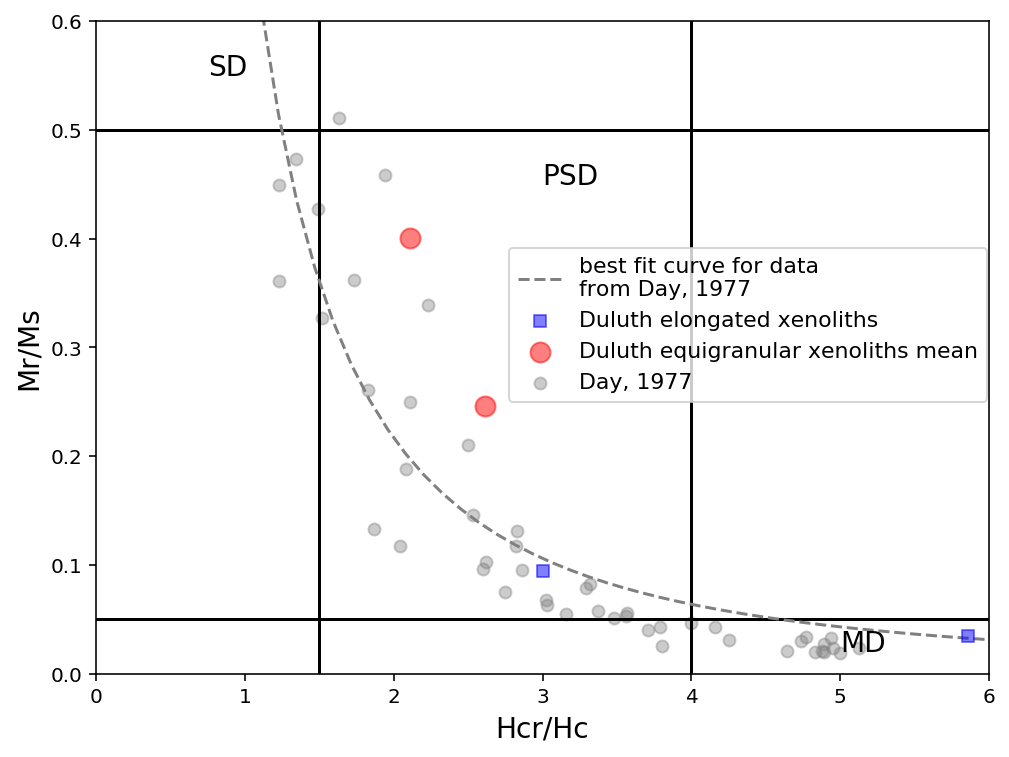

In [10]:
fig, ax = make_day_plot(DA_hysteresis_properties.iloc[:,1].tolist(), DA_hysteresis_properties.iloc[:,2].tolist(), 
              DA_hysteresis_properties.iloc[:,3].tolist(), DA_hysteresis_properties.iloc[:,4].tolist(), 
                        color = 'b', marker = 's', alpha=0.5,  label = 'Duluth elongated xenoliths', savefig = False)

DX1_4r_mean_hyst_stats = DX_hysteresis_properties.groupby('specimen').mean()

ax.scatter(DX1_4r_mean_hyst_stats.iloc[:,3]/DX1_4r_mean_hyst_stats.iloc[:,2], 
           DX1_4r_mean_hyst_stats.iloc[:,1]/DX1_4r_mean_hyst_stats.iloc[:,0], 
           color = 'r', marker='o', s=100, alpha = 0.5, label = 'Duluth equigranular xenoliths mean')


ax.scatter(Day1977a['Hrc/Hc'], Day1977a['Jrs/Js'], color='gray', alpha=0.4, label='Day, 1977')
hc_list = np.linspace(0,6)
mr_list = Day1977_fit[0]/hc_list**Day1977_fit[1]
ax.plot(hc_list, mr_list, color='gray', ls='--', label='best fit curve for data\nfrom Day, 1977')

ax.set_xlabel('Hcr/Hc', fontsize=14)
ax.set_ylabel('Mr/Ms', fontsize=14)
ax.set_xlim(0, 6)
ax.set_ylim(0, 0.6)
ax.text(5, 0.02, 'MD', fontsize=14)
ax.text(3, 0.45, 'PSD', fontsize=14)
ax.text(0.75, 0.55, 'SD', fontsize=14)
plt.legend(fontsize=11, bbox_to_anchor=(0.45, 0.4))
plt.savefig('code_output/day_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## make hysteresis plots

In [11]:
def get_hyst_data(excel_sheet, specimen_index):
    Blist = excel_sheet.iloc[:,0 + specimen_index * 4].tolist()[5:] # field list, unit is mT
    Mlist = excel_sheet.iloc[:,1 + specimen_index * 4].tolist()[5:] # moment list, unit is Am2/kg
    Mflist = excel_sheet.iloc[:,2 + specimen_index * 4].tolist()[5:] # mf list, unit is Am2/kg slope-corrected
#     Mlist_cor = excel_sheet.iloc[:,3 + specimen_index * 6].tolist()[5:] # corrected moment list, unit is Am2/kg
#     Mflist_cor = excel_sheet.iloc[:,4 + specimen_index * 6].tolist()[5:] # corrected mf list, unit is Am2/kg
    # plotting derivatives of the backfield curve
    Der = np.diff(Mflist)/np.diff(Blist)
    specimen_name = excel_sheet.columns[1 + specimen_index * 4]
    return {'Blist':Blist, 'Mlist':Mlist, 'Mflist':Mflist, 'derivative_list':Der, 'Name':specimen_name}

# plotting function directly output the plots as you specify the index of specimen in the list
def plot_hyst_data(excel_sheet, specimen_index, plot_raw_data = True, savefig = False):
    Blist = get_hyst_data(excel_sheet, specimen_index)['Blist']
    Mlist = get_hyst_data(excel_sheet, specimen_index)['Mlist']
    Mflist = get_hyst_data(excel_sheet, specimen_index)['Mflist']
#     Mlist_cor = get_hyst_data(excel_sheet, specimen_index)['Mlist_cor']
#     Mflist_cor = get_hyst_data(excel_sheet, specimen_index)['Mflist_cor']
    Der = get_hyst_data(excel_sheet, specimen_index)['derivative_list']
    specimen_name = get_hyst_data(excel_sheet, specimen_index)['Name']
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.axhline(y=0, lw=1, color='k')
    ax.axvline(x=0, lw=1, color='k')
    if plot_raw_data:
        ax.plot(Blist, Mlist, color = 'red', label = 'raw data')
    ax.plot(Blist, Mflist, color = 'blue', label = 'slope-corrected')
        
    ax.set_xlabel('B (mT)', fontsize=14)
    ax.set_ylabel('M (Am2/kg)', fontsize=14)
    ax.set_title(specimen_name + ' hysteresis loop', fontsize=14) 
    ax.grid()
    
    ax.legend(fontsize=14)
    if savefig == True:
        plt.savefig(specimen_name + '_hysteresis loop.pdf', bbox_inches='tight')
    return ax

In [12]:
hysteresis_measurements.head()

,specimen,DA2-r,Unnamed: 2,Unnamed: 3,specimen.1,DA4-A,Unnamed: 6,Unnamed: 7,specimen.2,DA4-r,...,DX1-4r.2,Unnamed: 26,Unnamed: 27,specimen.7,DX1-5r2,Unnamed: 30,Unnamed: 31,specimen.8,DX1-5r2.1,Unnamed: 34
0,T [K],294,NaN,NaN,T [K],294,NaN,NaN,T [K],294,...,294,NaN,NaN,T [K],294,NaN,NaN,T [K],294,NaN
1,dec [deg],0,NaN,NaN,dec [deg],0,NaN,NaN,dec [deg],0,...,0,NaN,NaN,dec [deg],0,NaN,NaN,dec [deg],0,NaN
2,inc [deg],0,NaN,NaN,inc [deg],0,NaN,NaN,inc [deg],0,...,0,NaN,NaN,inc [deg],0,NaN,NaN,inc [deg],0,NaN
3,Bapp [mT],M [Am2/kg],Mf [Am2/kg],NaN,Bapp [mT],M [Am2/kg],Mf [Am2/kg],NaN,Bapp [mT],M [Am2/kg],...,M [Am2/kg],Mf [Am2/kg],NaN,Bapp [mT],M [Am2/kg],Mf [Am2/kg],NaN,Bapp [mT],M [Am2/kg],Mf [Am2/kg]
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## DA2-r

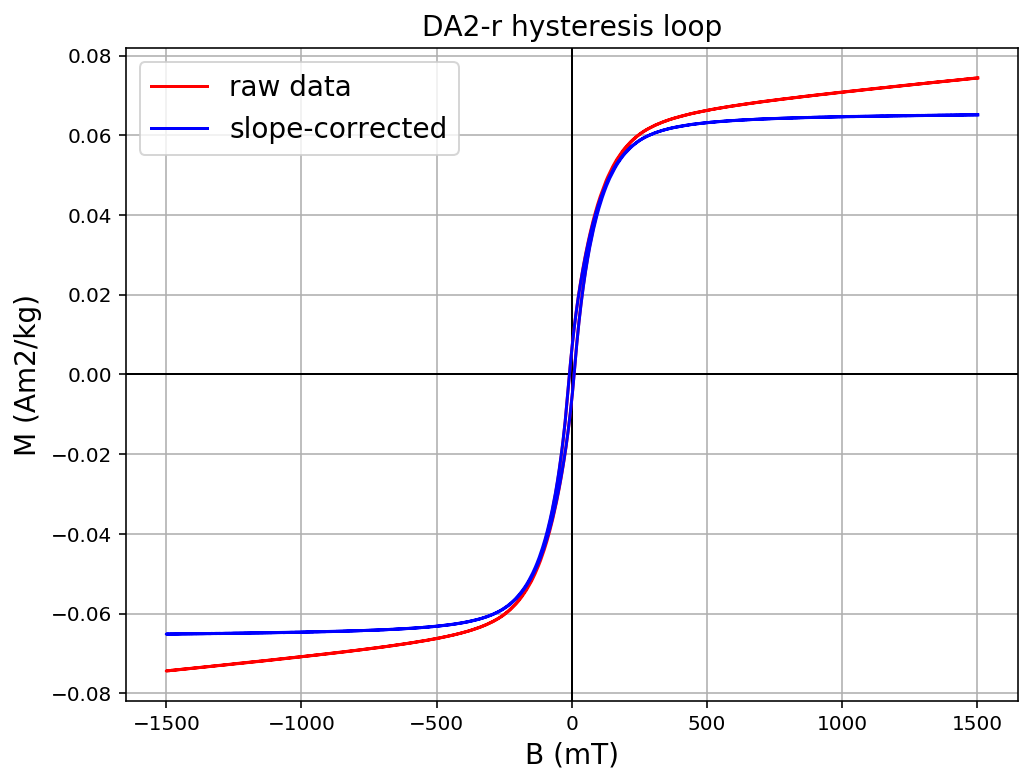

In [14]:
DA2_r_hyst = plot_hyst_data(hysteresis_measurements, 0, savefig = False)
plt.savefig('code_output/DA2_r_hyst.png', dpi=300, bbox_inches='tight')

### let's zoom in on the best hyst diagram for DX2-r

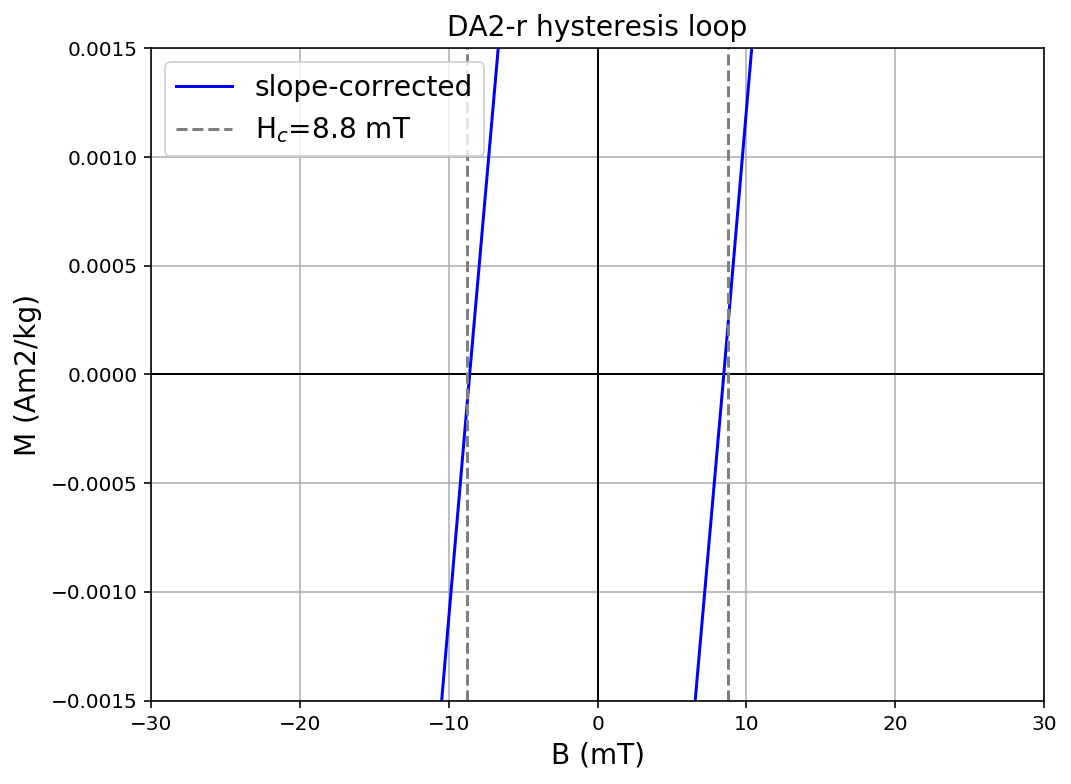

In [15]:
DA2_r_hyst = plot_hyst_data(hysteresis_measurements, 0, plot_raw_data=0, savefig = False)
DA2_r_hyst.set_xlim(-30, 30)
DA2_r_hyst.set_ylim(-0.0015, 0.0015)

Hc = 8.8
DA2_r_hyst.axvline(Hc, ls='--', color='gray', label='H$_c$='+str(Hc)+' mT')
DA2_r_hyst.axvline(-Hc, ls='--', color='gray')

plt.legend(fontsize=14)
plt.savefig('code_output/DA2_r_hyst_zoom.png', dpi=300, bbox_inches='tight')

plt.show()

## DA4-A (same specimen as DA4-r)

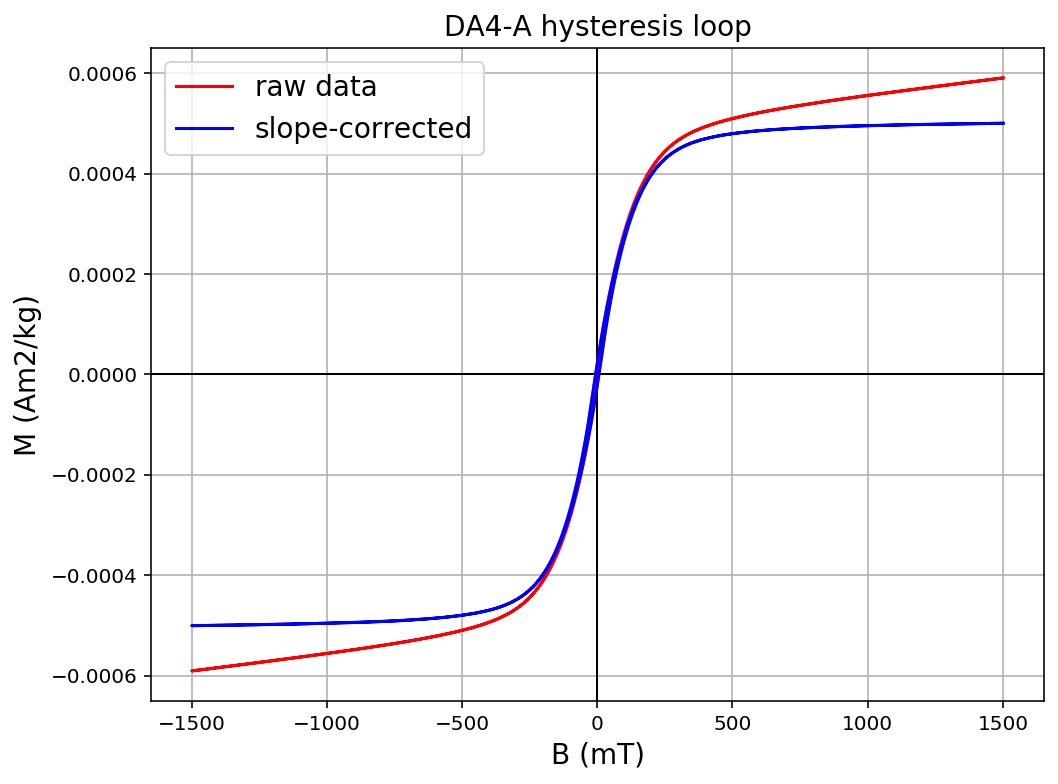

In [16]:
DA4_A_hyst = plot_hyst_data(hysteresis_measurements, 1, savefig = False)

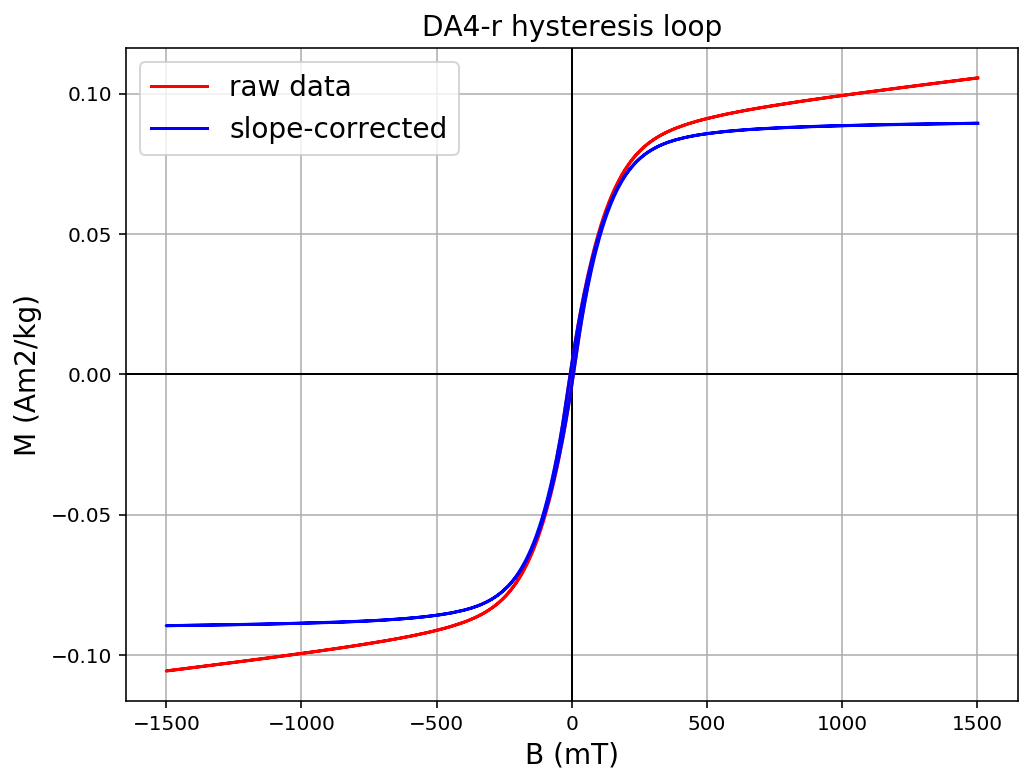

In [17]:
DA4_r_hyst = plot_hyst_data(hysteresis_measurements, 2, savefig = False)

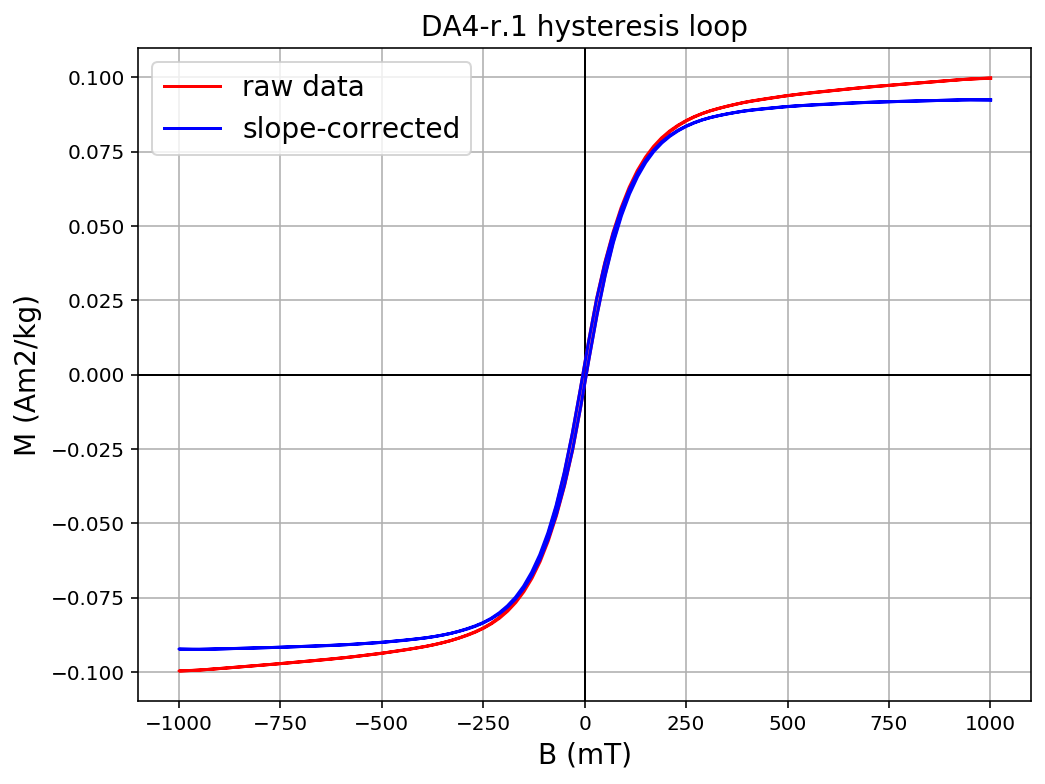

In [18]:
DA4_r_hyst_1 = plot_hyst_data(hysteresis_measurements, 3, savefig = False)
plt.savefig('code_output/DA4_r_hyst.png', dpi=300, bbox_inches='tight')


### let's zoom in on the best hyst diagram for DX4-r

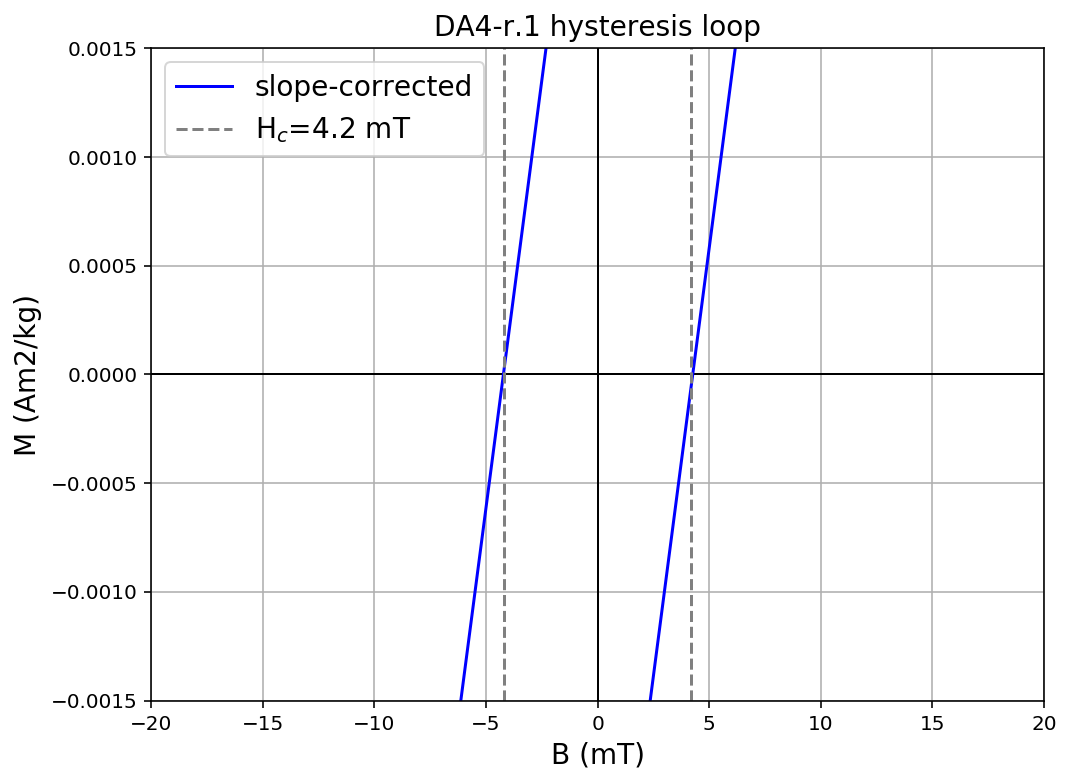

In [19]:
DA4_r_hyst_1 = plot_hyst_data(hysteresis_measurements, 3, plot_raw_data=0, savefig = False)
DA4_r_hyst_1.set_xlim(-20, 20)
DA4_r_hyst_1.set_ylim(-0.0015, 0.0015)

Hc = 4.2
DA4_r_hyst_1.axvline(Hc, ls='--', color='gray', label='H$_c$='+str(Hc)+' mT')
DA4_r_hyst_1.axvline(-Hc, ls='--', color='gray')

plt.legend(fontsize=14)
plt.savefig('code_output/DA4_r_hyst_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

## DX1-4r

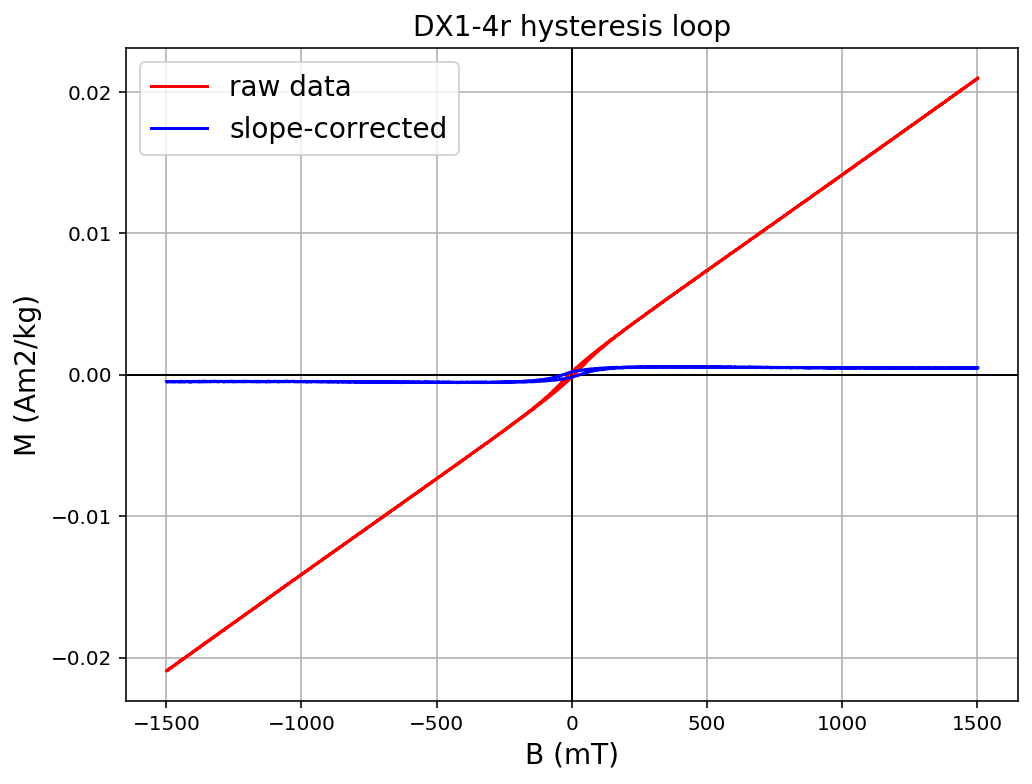

In [20]:
DX1_4r_hyst = plot_hyst_data(hysteresis_measurements, 4, savefig = False)

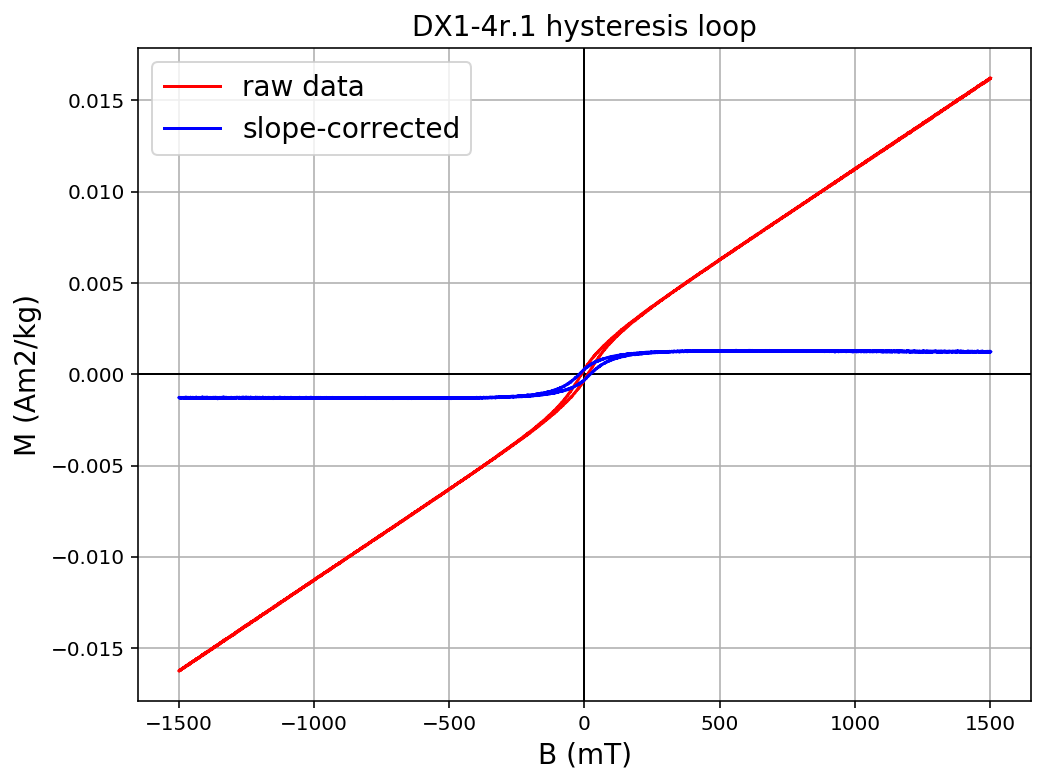

In [21]:
DX1_4r_hyst_1 = plot_hyst_data(hysteresis_measurements, 5, savefig = False)

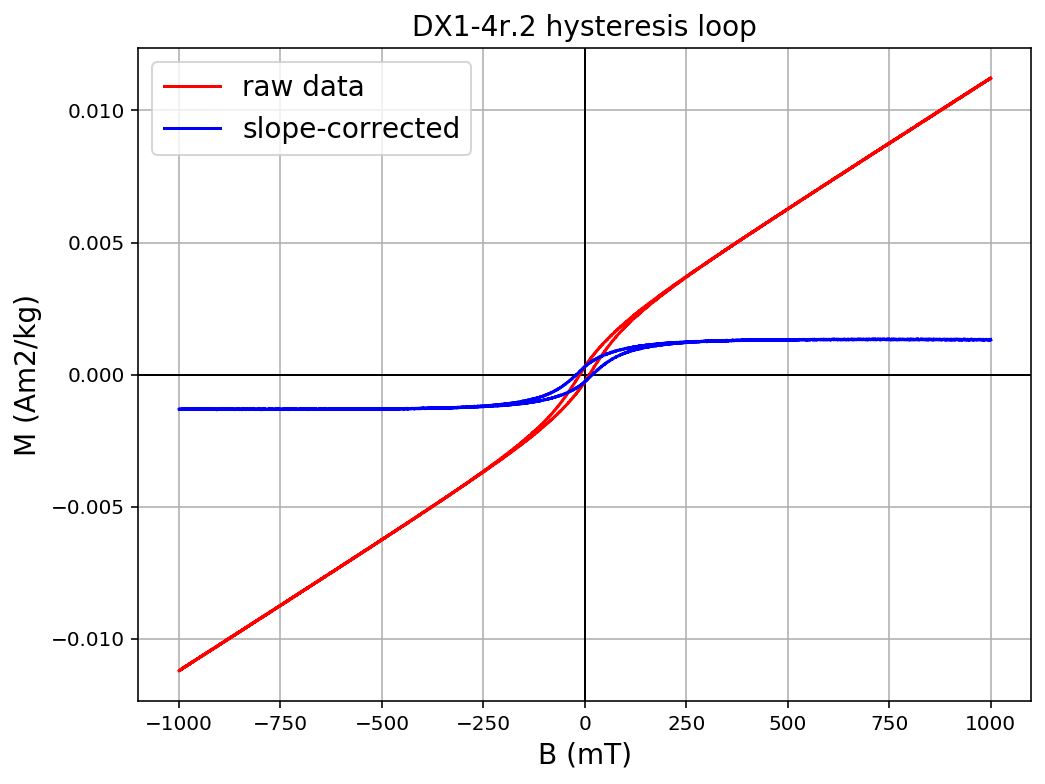

In [22]:
DX1_4r_hyst_2 = plot_hyst_data(hysteresis_measurements, 6, savefig = False)
plt.savefig('code_output/DX1_4r_hyst.png', dpi=300, bbox_inches='tight')


### let's zoom in on the best hyst diagram for DX1-4r

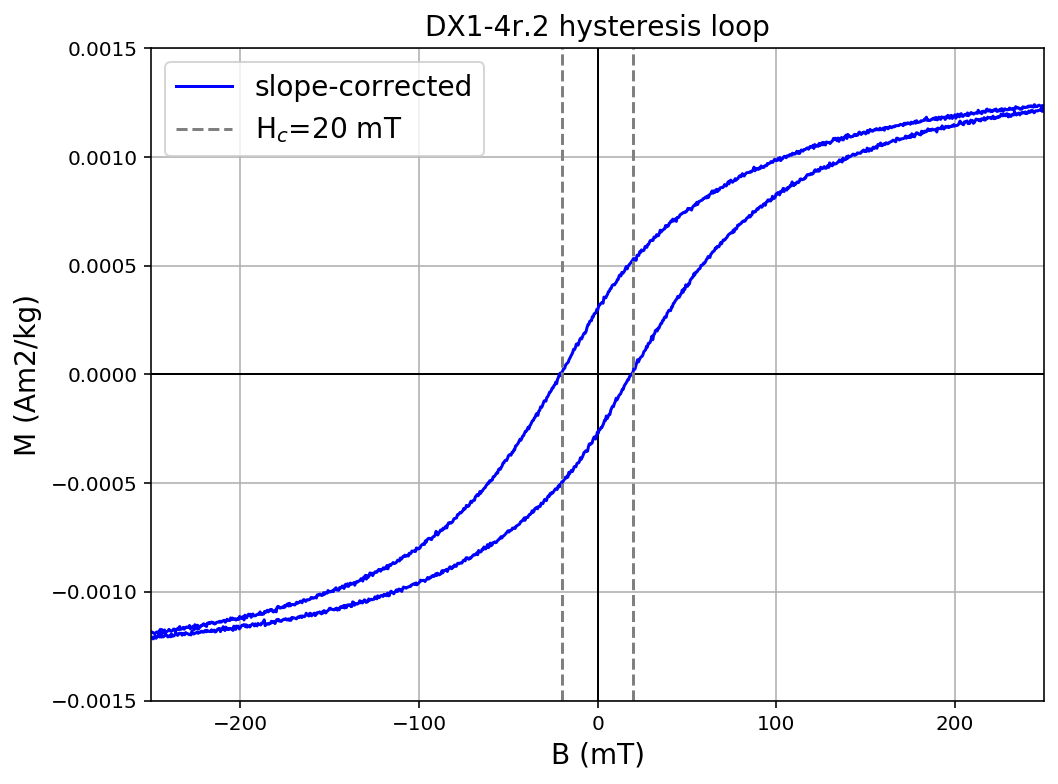

In [23]:
DX1_4r_hyst_2 = plot_hyst_data(hysteresis_measurements, 6, plot_raw_data=0, savefig = False)
DX1_4r_hyst_2.set_xlim(-250, 250)
DX1_4r_hyst_2.set_ylim(-0.0015, 0.0015)

Hc = 20
DX1_4r_hyst_2.axvline(Hc, ls='--', color='gray', label='H$_c$='+str(Hc)+' mT')
DX1_4r_hyst_2.axvline(-Hc, ls='--', color='gray')

plt.legend(fontsize=14)
plt.savefig('code_output/DX1_4r_hyst_zoom.png', dpi=300, bbox_inches='tight')

plt.show()

## DX1-5r

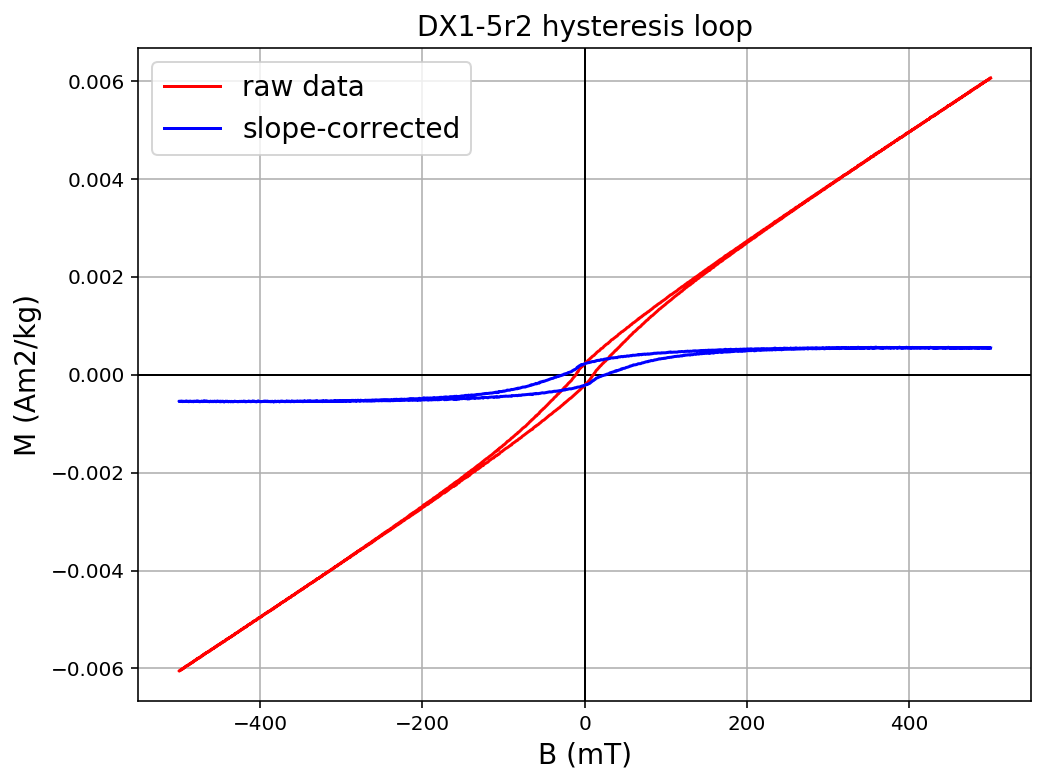

In [24]:
DX1_5r_hyst = plot_hyst_data(hysteresis_measurements, 7, savefig = False)

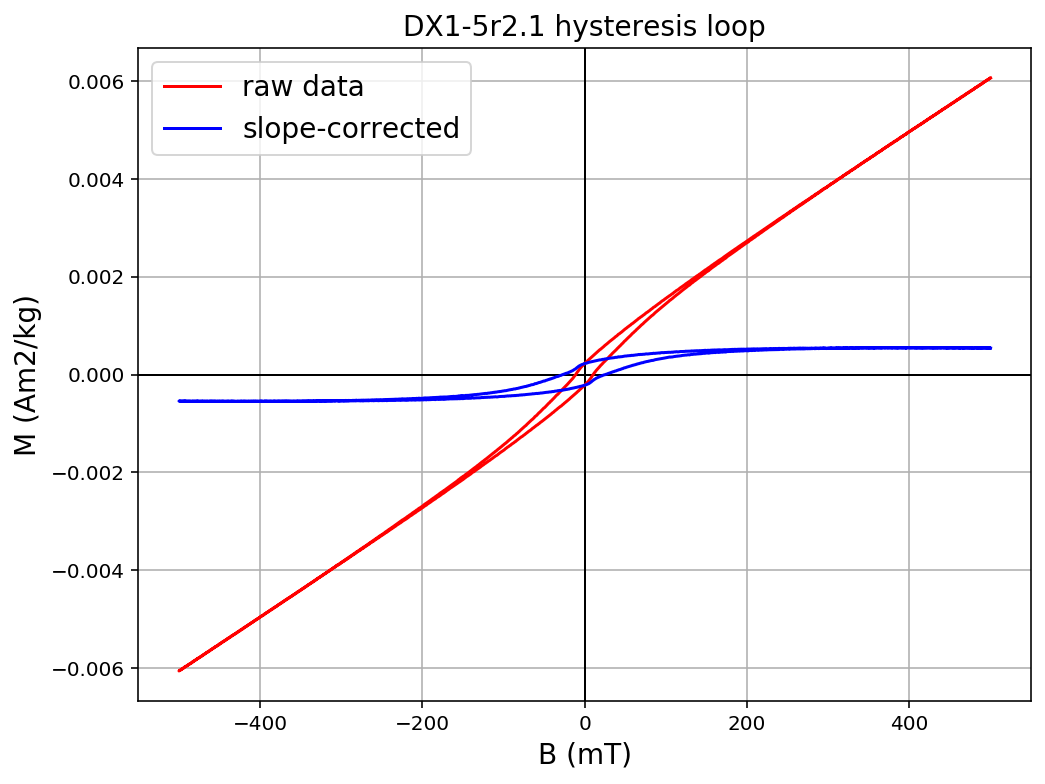

In [25]:
DX1_5r_hyst_2 = plot_hyst_data(hysteresis_measurements, 8, savefig = False)
plt.savefig('code_output/DX1_5r_hyst.png', dpi=300, bbox_inches='tight')

### let's zoom in on the best hyst diagram for DX1-5r

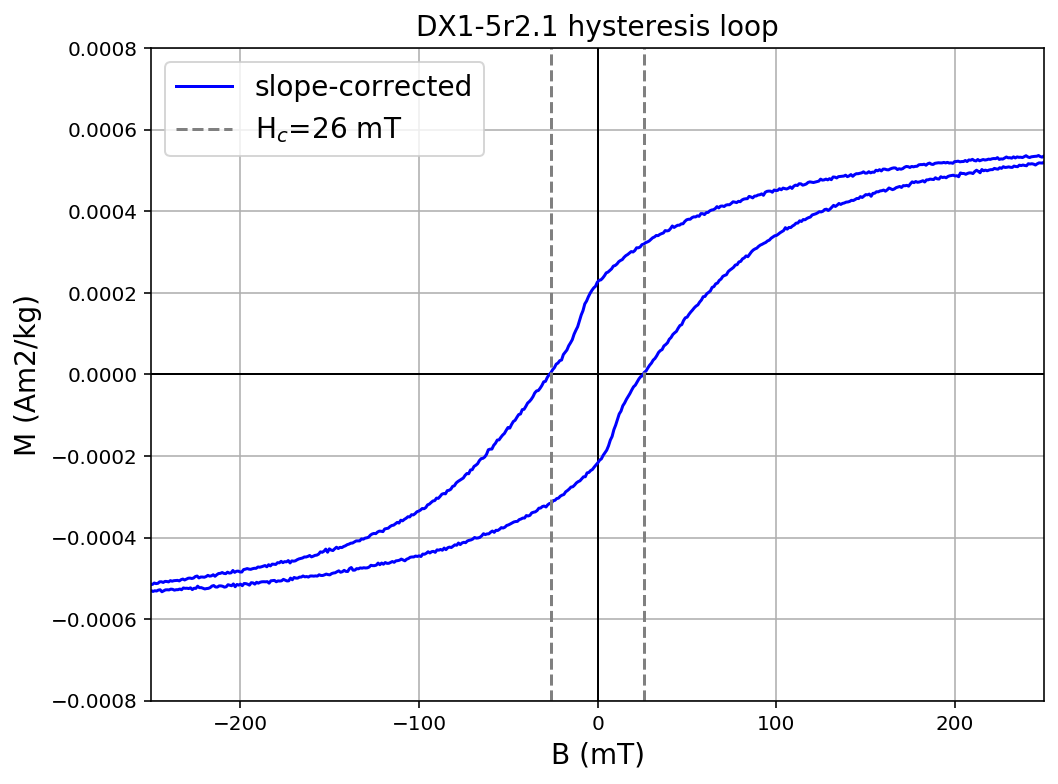

In [26]:
DX1_5r_hyst_2 = plot_hyst_data(hysteresis_measurements, 8, plot_raw_data=0, savefig = False)
DX1_5r_hyst_2.set_xlim(-250, 250)
DX1_5r_hyst_2.set_ylim(-0.0015, 0.0015)

Hc = 26
DX1_5r_hyst_2.axvline(Hc, ls='--', color='gray', label='H$_c$='+str(Hc)+' mT')
DX1_5r_hyst_2.axvline(-Hc, ls='--', color='gray')
DX1_5r_hyst_2.set_ylim(-0.0008, 0.0008)
plt.legend(fontsize=14)
plt.savefig('code_output/DX1_5r_hyst_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

## make backfield plots

In [3]:
VSM_bf_measurements.head()

,specimen,DA2-r,Unnamed: 2,specimen.1,DA4-A,Unnamed: 5,specimen.2,DA4-r,Unnamed: 8,specimen.3,...,DX1-4r,Unnamed: 14,specimen.5,DX1-4r.1,Unnamed: 17,specimen.6,DX1-4r.2,Unnamed: 20,specimen.7,DX1-5r2
0,T [K],294,NaN,T [K],294,NaN,T [K],294,NaN,T [K],...,294,NaN,T [K],294,NaN,T [K],294,NaN,T [K],294
1,dec [deg],0,NaN,dec [deg],0,NaN,dec [deg],0,NaN,dec [deg],...,0,NaN,dec [deg],0,NaN,dec [deg],0,NaN,dec [deg],0
2,inc [deg],0,NaN,inc [deg],0,NaN,inc [deg],0,NaN,inc [deg],...,0,NaN,inc [deg],0,NaN,inc [deg],0,NaN,inc [deg],0
3,Bapp [mT],M [Am2/kg],NaN,Bapp [mT],M [Am2/kg],NaN,Bapp [mT],M [Am2/kg],NaN,Bapp [mT],...,M [Am2/kg],NaN,Bapp [mT],M [Am2/kg],NaN,Bapp [mT],M [Am2/kg],NaN,Bapp [mT],M [Am2/kg]
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
def get_VSM_bf_data(excel_sheet, specimen_index, frac = 0.1, frac_der = 0.1):
    Blist = excel_sheet.iloc[:,0 + specimen_index * 3].dropna().tolist()[5:] # field list, unit is mT
    Mlist = excel_sheet.iloc[:,1 + specimen_index * 3].dropna().tolist()[5:] # moment list, unit is Am2/kg
    Blist = [-i for i in Blist]
    Mlist = [(i-min(Mlist)) for i in Mlist]

    logBlist = np.log10(Blist)

    lowess = sm.nonparametric.lowess
    lowessed = lowess(Mlist, Blist, frac=frac, missing='drop', return_sorted=False)
#     print(lowessed)
    # use the lowess curved to calculate a median destructive field
    # the definition for the median destructive field is the strength of the alternating magnetic field required to eliminate one-half of the remanent saturation magnetization
    saturation_m = max(lowessed)
    median_m = 0.5*saturation_m
    MDF = -1 # initialize fake value for MDF
    for i in range(len(lowessed)-1):
        this_difference = lowessed[i]-median_m
        next_difference = lowessed[i+1]-median_m
        if this_difference == 0:
            MDF = Blist[i]
            break
        elif this_difference > 0 and next_difference < 0:
            MDF = (Blist[i] + Blist[i+1])/2
            break
            
    Der = np.diff(lowessed)/np.diff(logBlist)
    Der = [-j for j in Der]
    Der = Der[1:]
    Der = [k/max(Der) for k in Der]
#     print(len(logBlist), len(Mlist), lowessed.shape, len(Der))
    lowessed_der = lowess(Der, logBlist[2:], frac=frac_der, xvals=logBlist[2:])
    specimen_name = excel_sheet.columns[1 + specimen_index * 3]
    return {'Blist':Blist, 'Log_Blist':logBlist, 'Mlist':Mlist, 'Name':specimen_name, 'Lowessed':lowessed, 'Derivative':Der, 'Lowessed_der':lowessed_der, 'MDM': median_m, 'MDF': MDF}

# plotting function directly output the plots as you specify the index of specimen in the list, and plots smoothed data
def plot_VSM_bf_data(excel_sheet, specimen_index, frac = 0.1, log = True, savefig = False, figname = '_VSM_bf.pdf'):
    data = get_VSM_bf_data(excel_sheet, specimen_index, frac = frac)
    
    Blist = data['Blist']
    logBlist = data['Log_Blist']
    Mlist = data['Mlist']
    lowessed = data['Lowessed']
    specimen_name = data['Name']
    MDM = data['MDM']
    MDF = data['MDF']

    plt.figure(figsize=(10,5))
    if log == True:
        plt.scatter(logBlist, Mlist, 15,color = 'grey', label = 'original data')
        plt.plot(logBlist, Mlist, color = 'black', label = 'original curve')
        plt.plot(logBlist, lowessed, color = 'red', label = 'smoothed curve')
        plt.plot([logBlist[1], np.log10(MDF)], [MDM, MDM], linestyle = 'dashed', color = 'grey', alpha = 0.5, label = 'median destructive field')
        plt.plot([np.log10(MDF), np.log10(MDF)], [min(Mlist), MDM], '--', alpha = 0.5, color = 'grey')
        plt.xticks([0, 1.0, 2.0, np.log10(500)], [1.0, 10.0, 100.0, 500.0])
        plt.xlabel('log B (mT)')
    else:
        plt.scatter(Blist, Mlist, 8, color = 'grey', label = 'original data')
        plt.plot(Blist, Mlist, color = 'black', label = 'original curve')
        plt.plot(logBlist, lowessed, color = 'red', label = 'smoothed curve')
        plt.plot([min(Blist), MDF], [MDM, MDM], '--', color = 'grey', alpha = 0.5, label = 'median destructive field')
        plt.plot([MDF, MDF], [min(Mlist), MDM], '--', alpha = 0.5, color = 'grey')
        plt.xlabel('B (mT)')
    
    plt.ylim(min(Mlist)-(max(Mlist)-min(Mlist))/50, max(Mlist)+(max(Mlist)-min(Mlist))/50)
    
    plt.ylabel('M (Am$^2$/kg)')
    plt.title(specimen_name + ' backfield curve')
    plt.legend()
    if savefig == True:
        plt.savefig('../Figure/Rock_mag_plots/'+specimen_name+figname)
    plt.show()
    return MDM, MDF


### Function for Cm and uncertainty bounds calculation



In [5]:
def Cm(Blist, Si=0, Bhi=1.5, DP=1, proportion=1):
    '''
    Blist is a list of field values
    Si is skewness, default is 0 for no skewness
    Bhi is the location of the mean of the skew normal distribution
    DP is the proportion factor that describes the height of the distribution
    '''
    Cm = skewnorm.pdf(Blist, Si, loc = Bhi, scale = DP)*proportion
    return Cm

def stats_list_in_list(Blist, list_in_list): # all lists in list should be of same dimension
    
    convert_array = np.array(list_in_list)
    
    mean = np.percentile(convert_array,50, axis=0)
    upper = np.percentile(convert_array,97.5, axis=0)
    lower = np.percentile(convert_array,2.5, axis=0)
#     print(mean, upper, lower)
    return {'mean':mean, 'upper':upper, 'lower':lower}

### fit function

In [6]:
def fit_function(logBlist, dMdBlist, in_list):
    '''
    this function fits the data of logB and dMdB to a skew normal distribution 
    it uses the user input in_list as initial guess for the parameters
    
    Format of in_list should follow: [Si, Bhi, DP] which is used by the Cm function
    one can initiate three components for fitting at most
    
    '''
    
    num_components = len(in_list)//4
    
    if num_components == 1:
        bounds = ((-1,1), (0,4), (0,100), (0,1))
    if num_components == 2:
        bounds = ((-1,1), (0,4), (0,100), (0,1),
                  (-1,1), (0,4), (0,100), (0,1))
    if num_components == 3:
        bounds = ((-1,1), (0,4), (0,100), (0,1),
                  (-1,1), (0,4), (0,100), (0,1), 
                  (-1,1), (0,4), (0,100), (0,1))
        
    def minimize_in_list(in_list):
        if num_components == 1:
            cm = cm1 = Cm(logBlist, in_list[0], in_list[1], in_list[2], in_list[3])
        elif num_components == 2:
            cm1 = Cm(logBlist, in_list[0], in_list[1], in_list[2], in_list[3])
            cm2 = Cm(logBlist, in_list[4], in_list[5], in_list[6], in_list[7])
            cm = np.add(cm1, cm2)
        elif num_components == 3:
            cm1 = Cm(logBlist, in_list[0], in_list[1], in_list[2], in_list[3])
            cm2 = Cm(logBlist, in_list[4], in_list[5], in_list[6], in_list[7])
            cm3 = Cm(logBlist, in_list[8], in_list[9], in_list[10], in_list[11])
            cm = np.sum([cm1, cm2, cm3], axis=0) 
        else:
            raise NameError('only 1-3 components are allowed')

        loss = np.abs(np.subtract(dMdBlist,cm))
        
        return np.sum(loss**2)
    
    output = minimize(minimize_in_list, in_list, method = 'Nelder-Mead')
    result = output.x
#     print(output.success)
    if num_components == 1:
        cm = cm1 = Cm(logBlist, result[0], result[1], result[2], result[3])
        return {'minimize_result':output, 'result_parameters':result, 'components':[cm1], 'all_components':cm}
    
    elif num_components == 2:
        cm1 = Cm(logBlist, result[0], result[1], result[2], result[3])
        cm2 = Cm(logBlist, result[4], result[5], result[6], result[7])
        cm = np.add(cm1, cm2)
        return {'minimize_result':output, 'result_parameters':result, 'components':[cm1, cm2], 'all_components':cm}
    
    elif num_components == 3:
        cm1 = Cm(logBlist, result[0], result[1], result[2], result[3])
        cm2 = Cm(logBlist, result[4], result[5], result[6], result[7])
        cm3 = Cm(logBlist, result[8], result[9], result[10], result[11])
        cm = np.sum([cm1, cm2, cm3], axis=0) 
        return {'minimize_result':output, 'result_parameters':result, 'components':[cm1,cm2,cm3], 'all_components':cm}
    
    return 

### error estimate

In [7]:
# error envolope estimate
def error_estimate(logBlist, dMdBlist, in_list, proportion = 0.95, n = 100, frac = 0.15, frac_der = 0.15):
    num_components = len(in_list)//4
    num_resample = int(proportion*len(logBlist))
    
    fit_result = fit_function(logBlist, dMdBlist, in_list)
    result_in_list = fit_result['result_parameters']
    original_cm = fit_result['all_components']
    result_components = fit_result['components']
    
    resample_result_parameters = list()
    
    data_array = np.array([logBlist, dMdBlist]).T
    
    for i in range(n):
        data_resample = data_array[np.random.choice(data_array.shape[0], num_resample), :].T
#         print(data_resample.shape)
        resample_result_parameters.append(list(fit_function(data_resample[0], data_resample[1], result_in_list)['result_parameters']))
    resample_result_parameters = np.array(resample_result_parameters).T
    
    print('resampling finished')
    
    if num_components == 1:
        # parameters
        
        Si_list_1 = resample_result_parameters[0]
        Bhi_list_1 = resample_result_parameters[1]
        DP_list_1 = resample_result_parameters[2]
        Proportion_list_1 = resample_result_parameters[3]
        
        Si_std_1 = stdev(Si_list_1)
        Bhi_std_1 = stdev(Bhi_list_1)
        DP_std_1 = stdev(DP_list_1)
        Proportion_std_1 = stdev(Proportion_list_1)
        
        print('parameter uncertainty calculation finished')
        
        # individual components
        holder_cm_1 = list()
        
        for m in range(len(Si_list_1)):
            holder_cm_1.append(Cm(logBlist, Si_list_1[m], Bhi_list_1[m], DP_list_1[m], Proportion_list_1[m]))
            
        stats_1 = stats_list_in_list(logBlist, holder_cm_1)
        
        print('fitting uncertainty envelope estimate finished')
        
        return {'stds':[Si_std_1, Bhi_std_1, DP_std_1, Proportion_std_1], 
                'means':[stats_1['mean']],
                'upper_bounds':[stats_1['upper']], 
                'lower_bounds':[stats_1['lower']], 
                'original_cm':original_cm}
    
    elif num_components == 2:
        
        # parameters

        Si_list_1 = resample_result_parameters[0]
        Bhi_list_1 = resample_result_parameters[1]
        DP_list_1 = resample_result_parameters[2]
        Proportion_list_1 = resample_result_parameters[3]
        
        Si_list_2 = resample_result_parameters[4]
        Bhi_list_2 = resample_result_parameters[5]
        DP_list_2 = resample_result_parameters[6]
        Proportion_list_2 = resample_result_parameters[7]
        
        Si_std_1 = stdev(Si_list_1)
        Bhi_std_1 = stdev(Bhi_list_1)
        DP_std_1 = stdev(DP_list_1)
        Proportion_std_1 = stdev(Proportion_list_1)
        
        Si_std_2 = stdev(Si_list_2)
        Bhi_std_2 = stdev(Bhi_list_2)
        DP_std_2 = stdev(DP_list_2)
        Proportion_std_2 = stdev(Proportion_list_2)
        
        print('parameter calculation finished')
        
        # individual components
        holder_cm_1 = list()
        holder_cm_2 = list()
        holder_cm_sum = list()
        
        for m in range(len(Si_list_1)):
            cm1 = Cm(logBlist, Si_list_1[m], Bhi_list_1[m], DP_list_1[m], Proportion_list_1[m])
            cm2 = Cm(logBlist, Si_list_2[m], Bhi_list_2[m], DP_list_2[m], Proportion_list_2[m])
            
            holder_cm_1.append(cm1)
            holder_cm_2.append(cm2)
            holder_cm_sum.append(np.add(cm1, cm2))
            
        stats_1 = stats_list_in_list(logBlist, holder_cm_1)
        stats_2 = stats_list_in_list(logBlist, holder_cm_2)
        stats_sum = stats_list_in_list(logBlist, holder_cm_sum)
        print('fitting uncertainty envelope estimate finished')
        
        return {'stds':[Si_std_1, Bhi_std_1, DP_std_1, Proportion_std_1,
                                    Si_std_2, Bhi_std_2, DP_std_2, Proportion_std_2], 
                'means':[stats_sum['mean'], stats_1['mean'], stats_2['mean']],
                'upper_bounds':[stats_sum['upper'], stats_1['upper'], stats_2['upper']], 
                'lower_bounds':[stats_sum['lower'], stats_1['lower'], stats_2['lower']], 
                'original_cm':original_cm}
        
    elif num_components == 3:
        # parameters

        Si_list_1 = resample_result_parameters[0]
        Bhi_list_1 = resample_result_parameters[1]
        DP_list_1 = resample_result_parameters[2]
        Proportion_list_1 = resample_result_parameters[3]
        
        Si_list_2 = resample_result_parameters[4]
        Bhi_list_2 = resample_result_parameters[5]
        DP_list_2 = resample_result_parameters[6]
        Proportion_list_2 = resample_result_parameters[7]
        
        Si_list_3 = resample_result_parameters[8]
        Bhi_list_3 = resample_result_parameters[9]
        DP_list_3 = resample_result_parameters[10]
        Proportion_list_3 = resample_result_parameters[11]
        
        Si_std_1 = stdev(Si_list_1)
        Bhi_std_1 = stdev(Bhi_list_1)
        DP_std_1 = stdev(DP_list_1)
        Proportion_std_1 = stdev(Proportion_list_1)
        
        Si_std_2 = stdev(Si_list_2)
        Bhi_std_2 = stdev(Bhi_list_2)
        DP_std_2 = stdev(DP_list_2)
        Proportion_std_2 = stdev(Proportion_list_2)
        
        Si_std_3 = stdev(Si_list_3)
        Bhi_std_3 = stdev(Bhi_list_3)
        DP_std_3 = stdev(DP_list_3)
        Proportion_std_3 = stdev(Proportion_list_3)
        
        print('parameter calculation finished')
        
        # individual components
        holder_cm_1 = list()
        holder_cm_2 = list()
        holder_cm_3 = list()
        holder_cm_sum = list()
        
        for m in range(len(Si_list_1)):
            cm1 = Cm(logBlist, Si_list_1[m], Bhi_list_1[m], DP_list_1[m], Proportion_list_1[m])
            cm2 = Cm(logBlist, Si_list_1[m], Bhi_list_2[m], DP_list_2[m], Proportion_list_2[m])
            cm3 = Cm(logBlist, Si_list_1[m], Bhi_list_3[m], DP_list_3[m], Proportion_list_3[m])
            
            holder_cm_1.append(cm1)
            holder_cm_2.append(cm2)
            holder_cm_3.append(cm3)
            holder_cm_sum.append(np.sum([cm1, cm2, cm3], axis=0) )
            
        stats_1 = stats_list_in_list(logBlist, holder_cm_1)
        stats_2 = stats_list_in_list(logBlist, holder_cm_2)
        stats_3 = stats_list_in_list(logBlist, holder_cm_3)
        stats_sum = stats_list_in_list(logBlist, holder_cm_sum)
        print('fitting uncertainty envelope estimate finished')
        
        return {'stds':[Si_std_1, Bhi_std_1, DP_std_1, Proportion_std_1,
                                    Si_std_2, Bhi_std_2, DP_std_2, Proportion_std_2,
                                    Si_std_3, Bhi_std_3, DP_std_3, Proportion_std_3,], 
                'upper_bounds':[stats_sum['upper'],stats_1['upper'], stats_2['upper'], stats_3['upper']], 
                'lower_bounds':[stats_sum['lower'],stats_1['lower'], stats_2['lower'], stats_3['lower']], 
                'means':[stats_sum['mean'],stats_1['mean'], stats_2['mean'], stats_3['mean']], 
                'original_cm':original_cm}

### plot unmix data

In [8]:
# unmix function
def plot_unmix_data(logBlist, dMdBlist, specimen_name, in_list):
    fit_result = fit_function(logBlist, dMdBlist, in_list)
    minimize_result = fit_result['minimize_result']
    result_parameters = fit_result['result_parameters']
    components = fit_result['components']
    all_components = fit_result['all_components']
    
    plt.figure(figsize=(10,5))

    # plot raw data
    plt.scatter(logBlist, dMdBlist, 15, color = 'grey', label = 'original data')
    
    # plot optimized result
    if len(components) != 1:
        for i in range(len(components)):
            plt.plot(logBlist, components[i], color = 'C' + str(i+2), label = 'component ' + str(i+1))
    plt.plot(logBlist, all_components, color = 'orange', label = 'total fit')
    plt.xlabel('log B (mT)')
    plt.ylabel('dM/dB')
    plt.title(specimen_name + ' coercivity spectrum')
    plt.legend()
    plt.show()
    
    return logBlist[np.argmax(all_components)], result_parameters[2]

### plot unmix data with uncertainties

In [91]:
def plot_error_estimate(logBlist, dMdBlist, specimen_name, in_list, proportion = 0.95, n = 100, 
                        init_color_code_components = ['darkorange', 'darkblue', 'purple', 'darkgreen'], init_color_code_error = ['orange', 'blue', 'orchid', 'green'], 
                        savefig = False):
    default_color_code_components = ['darkorange', 'darkblue', 'purple', 'darkgreen']
    default_color_code_error = ['orange', 'blue', 'orchid', 'green']
    
    color_code_components = []
    color_code_error = []
    num_init_color = len(init_color_code_components)
    # this allows customization of color curves
    if num_init_color < 4:
        color_code_components.extend(init_color_code_components)
        color_code_components.extend(default_color_code_components[num_init_color:])
        
        color_code_error.extend(init_color_code_error)
        color_code_error.extend(default_color_code_error[num_init_color:])
        
    else: 
        color_code_components = init_color_code_components
        color_code_error = init_color_code_error
        
    num_components = len(in_list)//4
    error_estimate_result = error_estimate(logBlist, dMdBlist, in_list, proportion, n)
    std_Si_Bhi_DP = error_estimate_result['stds']
    upper_bounds = error_estimate_result['upper_bounds']
    lower_bounds = error_estimate_result['lower_bounds']
    means = error_estimate_result['means']
    original_cm = error_estimate_result['original_cm']
    
#     print('means', means, 'u
# pper', upper_bounds, 'lower', lower_bounds)
    
    plt.figure(figsize = (10,5))
    # plot raw data
    plt.scatter(logBlist, dMdBlist, 15, color = 'grey', label = 'original data')
#     plt.plot(logBlist, original_cm, color = 'darkorange',label = 'original fit')
    # plot mean curves for all components and their sum
    for i in range(len(upper_bounds)):  
        if i == 0:
            label = 'total fit'
        else:
            label = 'component ' + str(i)
        plt.plot(logBlist, means[i], color=color_code_components[i], label = label)
        plt.fill_between(logBlist, upper_bounds[i], lower_bounds[i], color=color_code_error[i], alpha='0.5')
    plt.xticks(np.log10([1, 10, 100, 300, 1000]), [1, 10, 100, 300, 1000])
    plt.xlabel('B (mT)')
    plt.ylabel('dM/dB')
    plt.title(specimen_name + ' coercivity spectrum')
    plt.legend()
    if savefig == True:
        plt.savefig('code_output/' + specimen_name + '_umix.pdf')
    plt.show()
    
    return error_estimate_result, logBlist, dMdBlist

## DA2-r

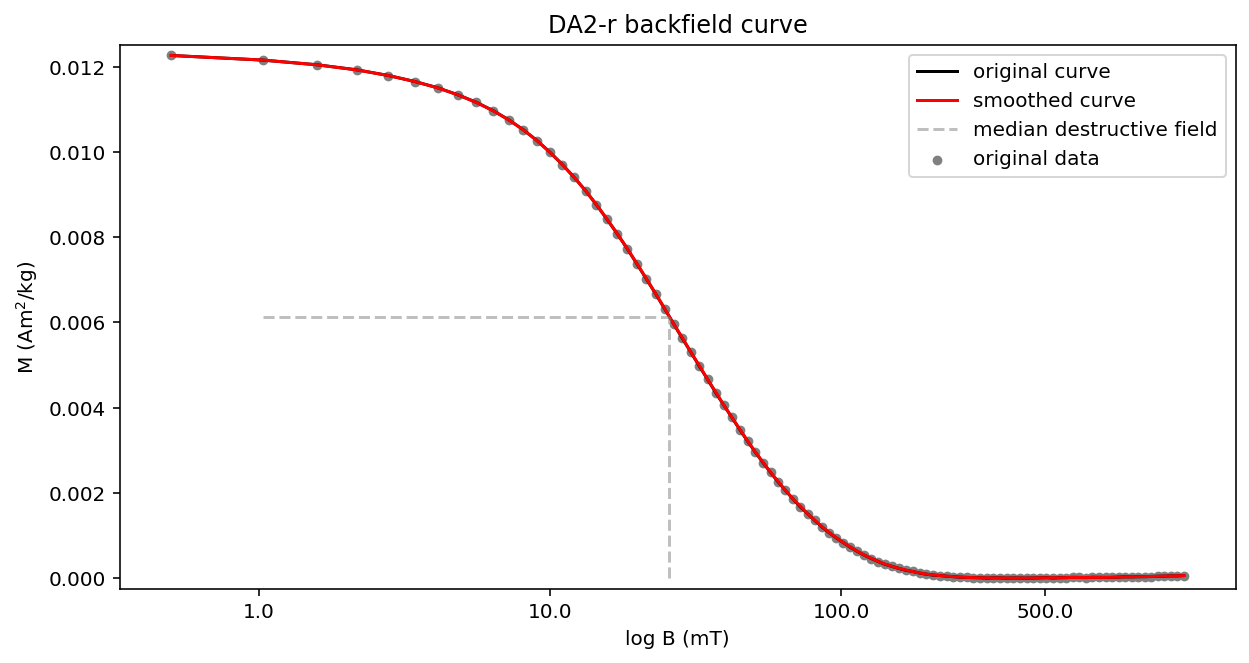

In [53]:
DA2_r_MDF = plot_VSM_bf_data(VSM_bf_measurements, 0, 0.05, log = True)

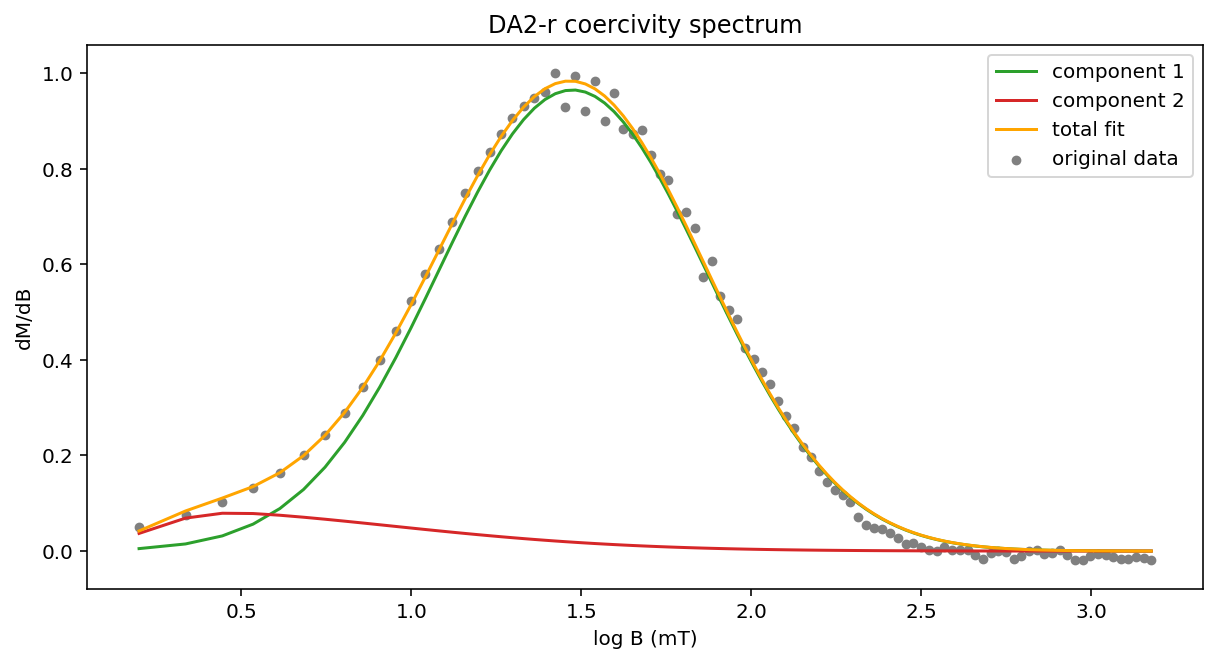

In [66]:
DA2_r_logBlist = get_VSM_bf_data(VSM_bf_measurements, 0, 0.05, 0.01)['Log_Blist'][2:]
DA2_r_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 0, 0.05, 0.01)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 0, 0.05, 0.01)['Name']

DA2_r_in_list = [1, 1.2, .5, 1, 
                 1, 0.5, 0.5, 0.1]
DA2_r_fit_result = plot_unmix_data(DA2_r_logBlist, DA2_r_dMdBlist, specimen_name, DA2_r_in_list)

resampling finished
parameter calculation finished
fitting uncertainty envelope estimate finished


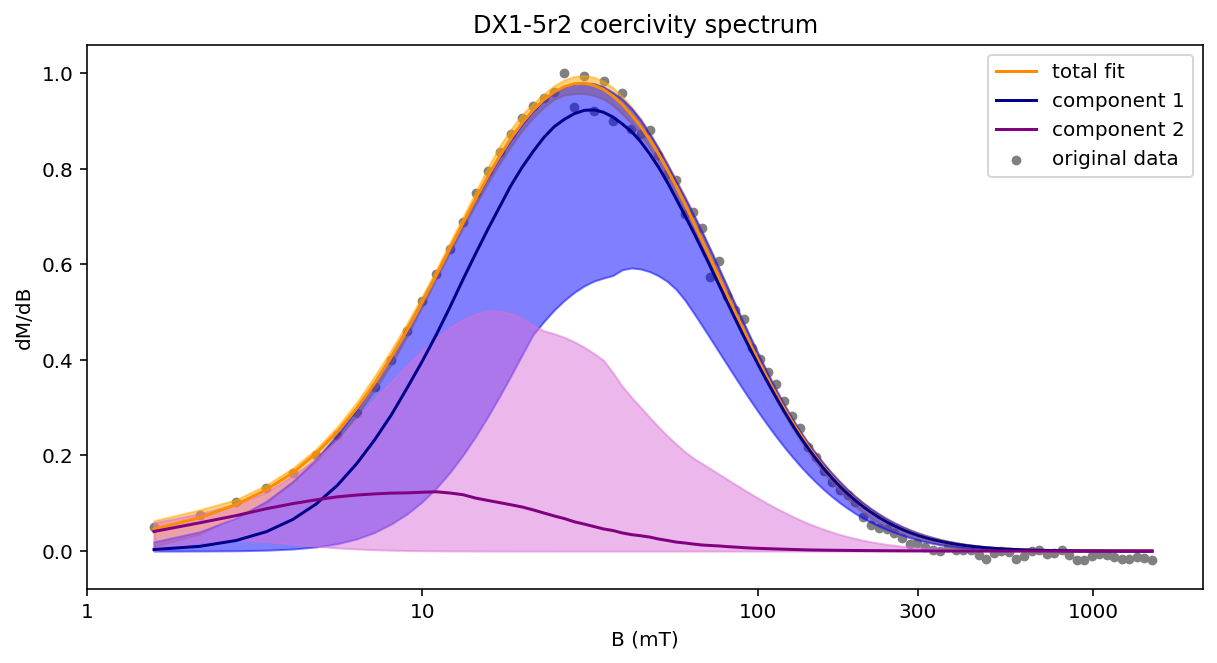

In [93]:
DA2_r_fit_error = plot_error_estimate(DA2_r_logBlist, DA2_r_dMdBlist, specimen_name, DA2_r_in_list, proportion=0.98, n=100, savefig = True)

## DA4-r

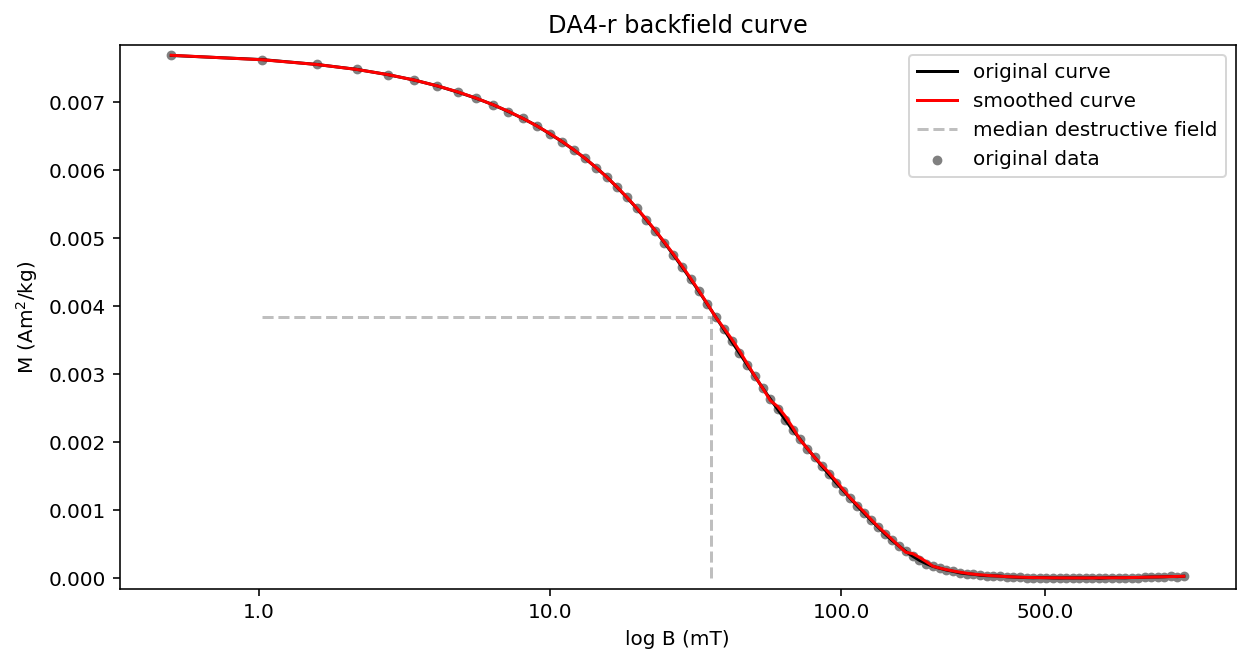

In [84]:
DA4_A_MDF = plot_VSM_bf_data(VSM_bf_measurements, 2, 0.1, log = True)

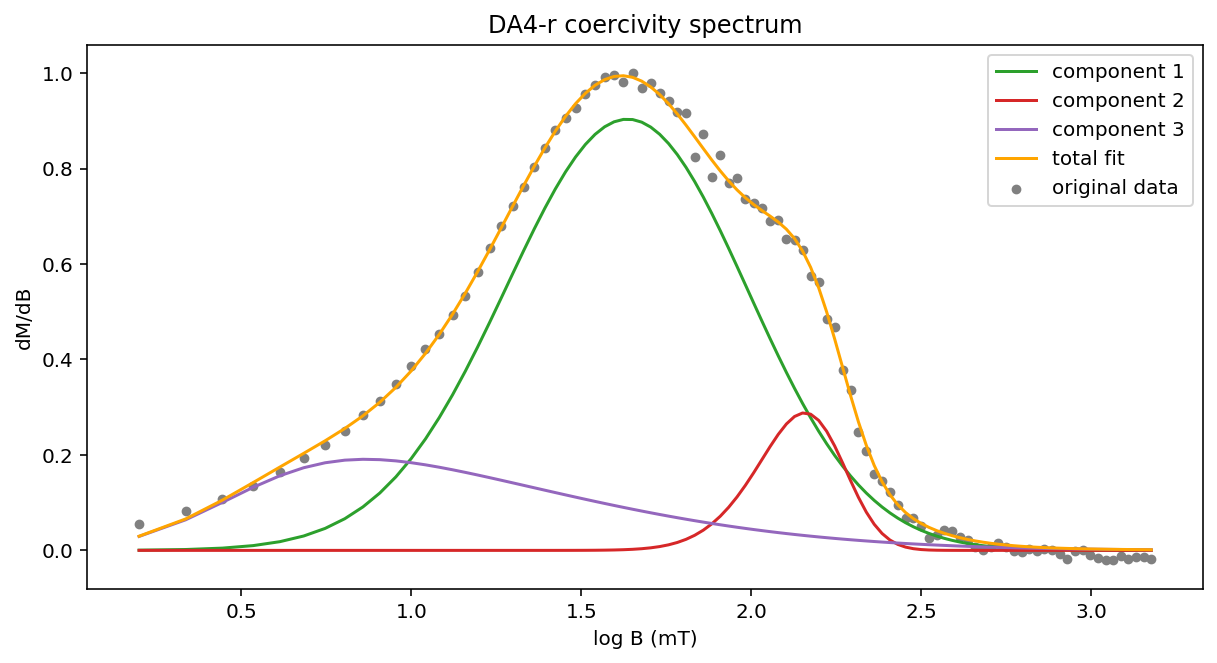

In [85]:
DA4_A_logBlist = get_VSM_bf_data(VSM_bf_measurements, 2, 0.05, 0.05)['Log_Blist'][2:]
DA4_A_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 2, 0.05, 0.05)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 2, 0.05, 0.05)['Name']

DA4_A_in_list = [0.9, 1.4, .4, 0.8,
                 1, 1.9, .3, 0.1, 
                 1, 0.5, 0.5, 0.1]
DA4_A_fit_result = plot_unmix_data(DA4_A_logBlist, DA4_A_dMdBlist, specimen_name, DA4_A_in_list)

resampling finished
parameter calculation finished
fitting uncertainty envelope estimate finished


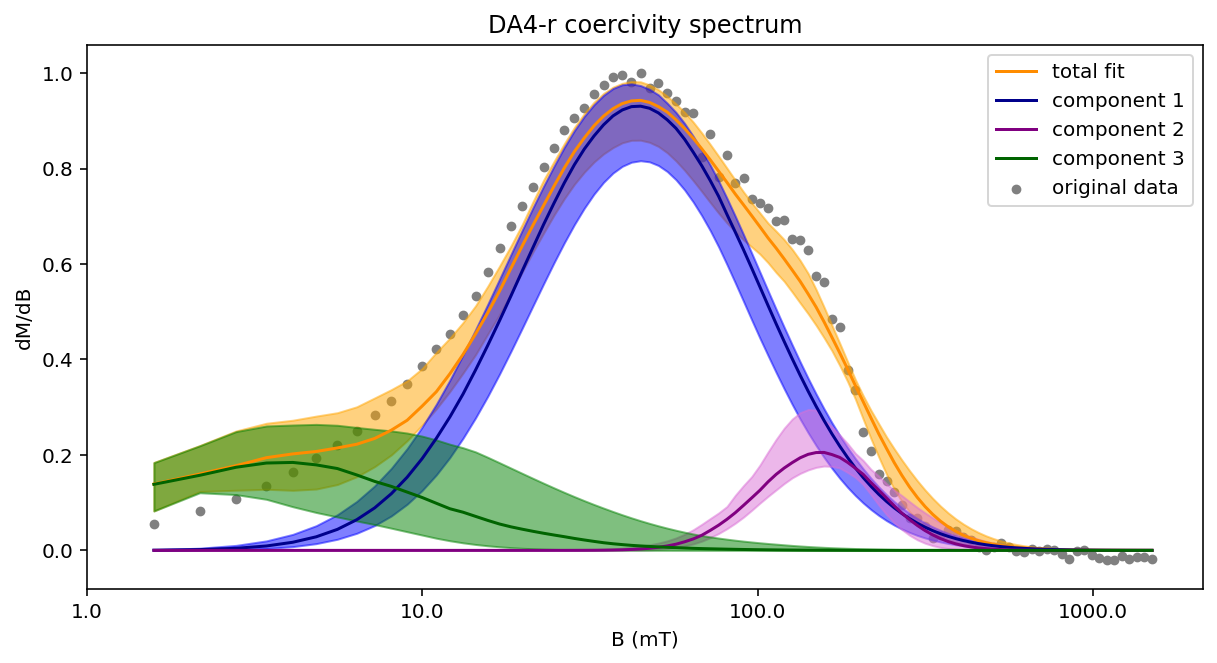

In [86]:
DA4_A_fit_error = plot_error_estimate(DA4_A_logBlist, DA4_A_dMdBlist, specimen_name, DA4_A_in_list, proportion=0.95, n=100, savefig = True)

## DX1-4r

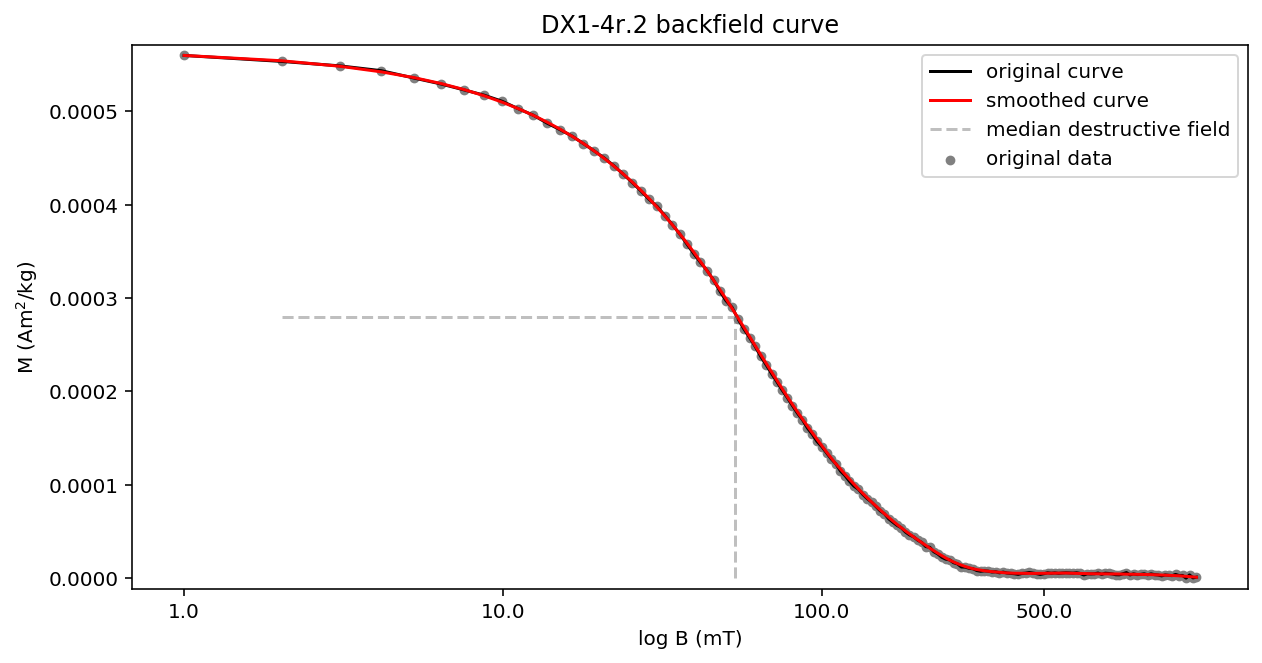

In [73]:
DX1_4r_MDF = plot_VSM_bf_data(VSM_bf_measurements, 6, 0.1, log = True)

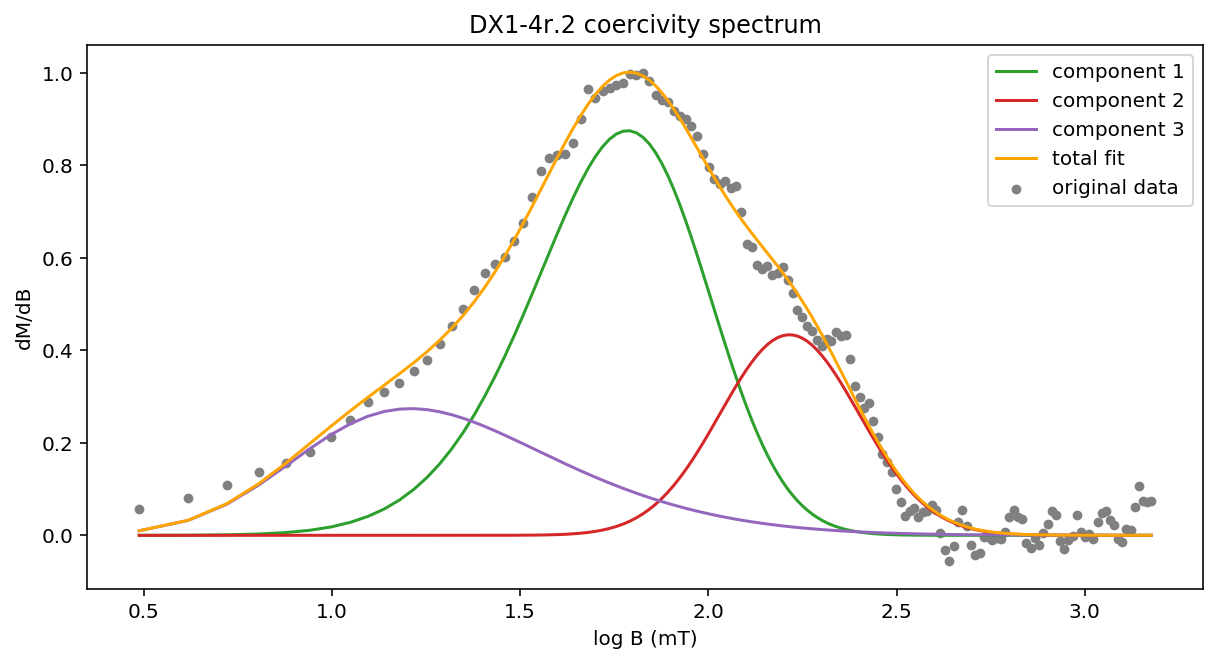

In [78]:
DX1_4r_logBlist = get_VSM_bf_data(VSM_bf_measurements, 6, 0.05, 0.05)['Log_Blist'][2:]
DX1_4r_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 6, 0.05, 0.05)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 6, 0.05, 0.05)['Name']

DX1_4r_in_list = [0.9, 1.4, .4, 0.8,
                 1, 1.9, .3, 0.1, 
                 1, 0.5, 0.5, 0.1]
DX1_4r_fit_result = plot_unmix_data(DX1_4r_logBlist, DX1_4r_dMdBlist, specimen_name, DX1_4r_in_list)

resampling finished
parameter calculation finished
fitting uncertainty envelope estimate finished


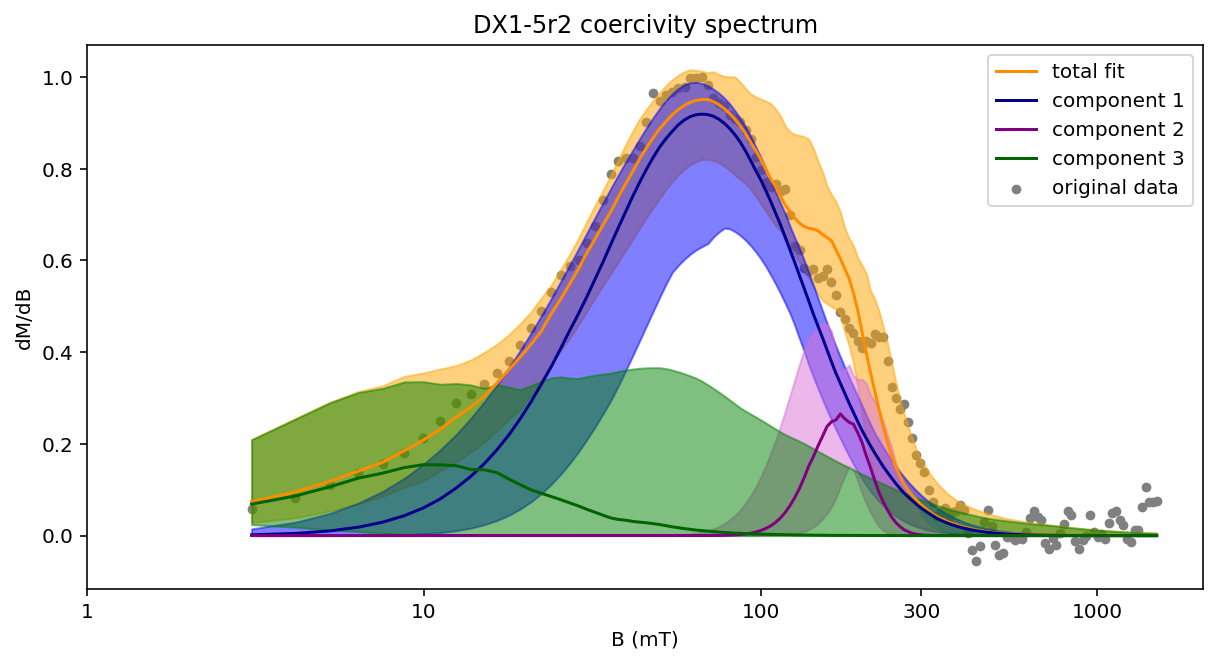

In [98]:
DX1_4r_fit_error = plot_error_estimate(DX1_4r_logBlist, DX1_4r_dMdBlist, specimen_name, DX1_4r_in_list, proportion=0.99, n=100, savefig = True)

## DX1-5r

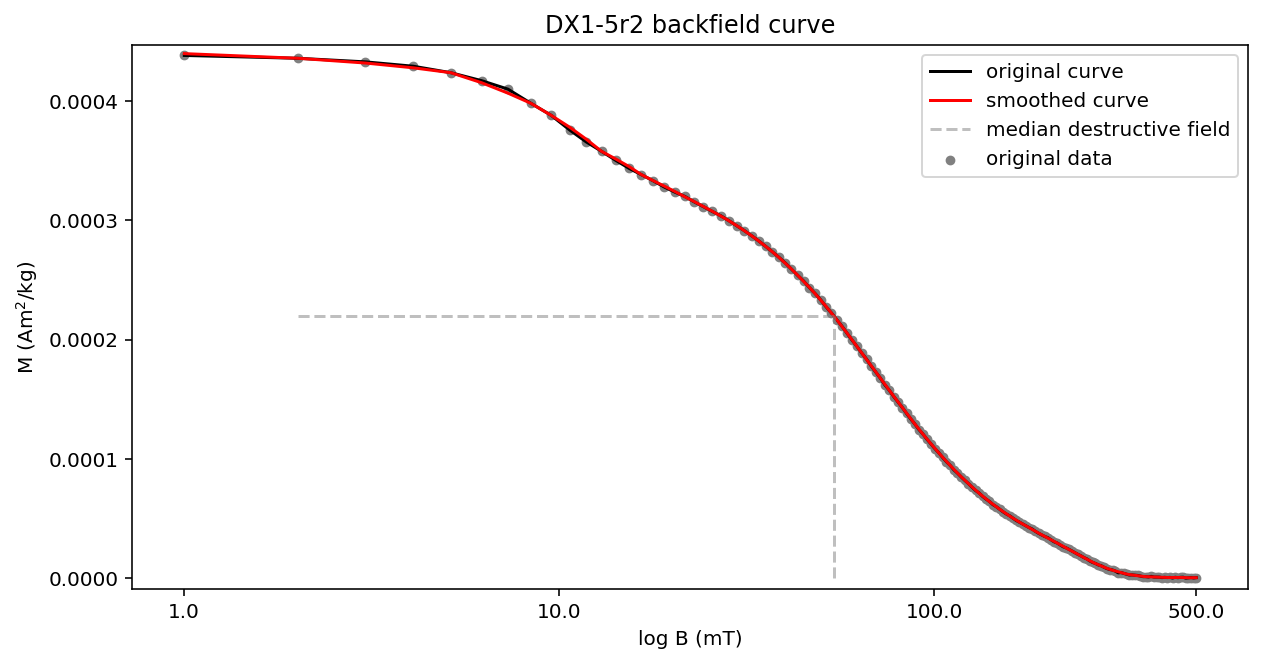

In [95]:
DX1_5r_MDF = plot_VSM_bf_data(VSM_bf_measurements, 7, 0.05, log = True)

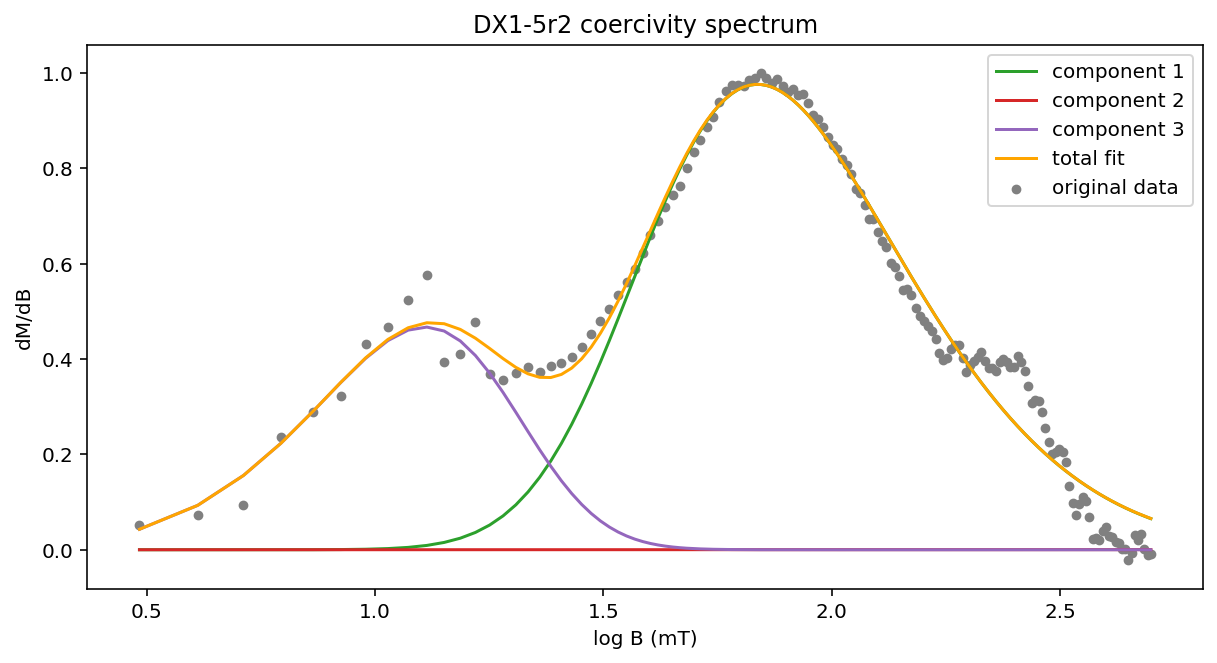

In [103]:
DX1_5r_logBlist = get_VSM_bf_data(VSM_bf_measurements, 7, 0.05, 0.05)['Log_Blist'][2:]
DX1_5r_dMdBlist = get_VSM_bf_data(VSM_bf_measurements, 7, 0.05, 0.05)['Derivative']
specimen_name = get_VSM_bf_data(VSM_bf_measurements, 7, 0.05, 0.05)['Name']

DX1_5r_in_list = [0.9, 1.7, .4, 0.7,
                 0.9, 2.4, .9, 0.3, 
                 1, 1.0, 0.5, 0.1]
DX1_5r_fit_result = plot_unmix_data(DX1_5r_logBlist, DX1_5r_dMdBlist, specimen_name, DX1_5r_in_list)

resampling finished
parameter calculation finished
fitting uncertainty envelope estimate finished


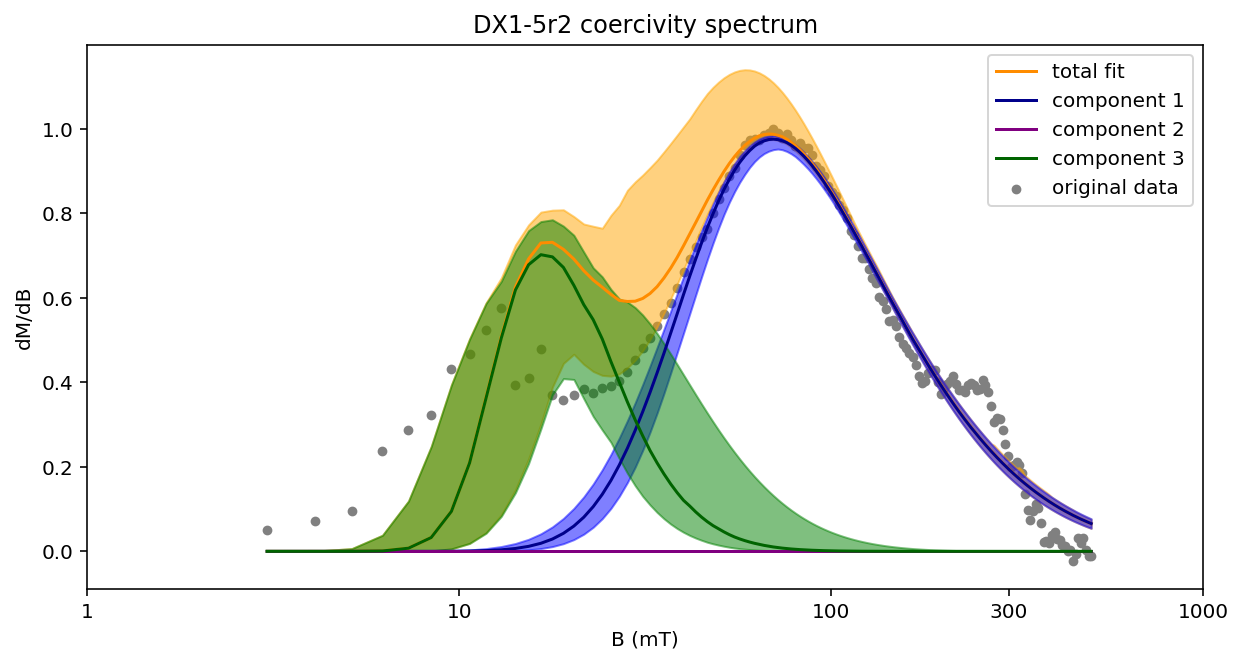

In [96]:
DX1_5r_fit_error = plot_error_estimate(DX1_5r_logBlist, DX1_5r_dMdBlist, specimen_name, DX1_5r_in_list, proportion=0.98, n=100, savefig = True)